# Classify text with BERT

This project aims to learn how to classify movie reviews based on their sentiments from the text using the BERT model. Below is what I learned from this project:

1. About the BERT model - its characteristics and architecture.
2. How to preprocess data for BERT.
3. How to load pre-trained BERT models from the TensorflowHub.
4. How to build a model for sentiment analysis using BERT and fine-tune it.
5. How to combat overfitting in NLP problems.

[Tutorial Source](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

Install dependencies:

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install tf-models-official

In [ ]:
import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel("ERROR")

In [ ]:
print(tf.__version__)

2.15.0


To check if you have a GPU attached. Run the following.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

path = "/content/"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1.tar.gz", url, untar=True, cache_dir=path, cache_subdir=""
)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 23s 0us/step


I was able to get some information about the dataset by reading the README file:


This dataset contains movie reviews along with their associated binary sentiment polarity labels.

The core dataset contains 50,000 reviews split evenly into `25k train and 25k test sets` and `negative/positive ratio is 1/1`.

There are two top-level directories [train/, test/] corresponding to the training and test sets. Each contains [pos/, neg/] directories for the reviews with binary labels positive and negative.

Reviews are stored in text files named following the
convention `[[id]_[rating].txt]`. For example, the file
[test/pos/200_8.txt] is the text for a positive-labeled test set example with unique id 200 and star rating 8/10 from IMDb.

In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets.

Below is an example of a movie review data (exerpt). As you can see, movie review is usually more than a sentence and nuanced:
> Earth has been destroyed ... As for the story, it's a blending of elements from better films and stories, including Ten Little Indians, The Most Dangerous Game, and Escape From New York. The Final Executioner moves along at a fair pace and provides reasonable entertainment for less discriminate action fans.



Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

As I expected, there are 2 classes (pos and neg) and 25k files for each classes, total of 50k files.
* Train 20000
* Validation 5000
* Test 25000

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed,
)

# This will prefetch batches of data and make sure that there is always one ready for the GPU.
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed,
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    path + "aclImdb/test", batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [ ]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(1):
        print(f"Review: {text_batch.numpy()[i].decode()}") # decode byte-string to string
        label = label_batch.numpy()[i]
        print(f"Label : {label} ({class_names[label]})")

Review: "Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn't all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that's all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)
Label : 0 (neg)


## Loading models from TensorFlow Hub

For the purpose of this exercise, I used a model called Small BERT. Small BERT has the same general architecture as the original BERT but the has fewer and/or smaller Transformer blocks.

Some other popular BERT models are BERT Base, ALBERT, BERT Experts, Electra. See the continued learning section at the end of this lab for more info.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) with varying size and capabilities.

### Choose a BERT model to fine-tune

In [ ]:
# defining the URL of the smallBERT model to use
# 4 layers, 512 hidden units, and 8 attention units
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# Every BERT model from TF hub is associated with a dedicated preprocessor.
# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models.

Note: A [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

Use `hub.KerasLayer` to initialize the preprocessing

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

Call the preprocess model function and pass text_test

In [ ]:
text_test = ["This is such an amazing movie! Ohh, yes."]
text_preprocessed = bert_preprocess_model(text_test)

truc = 25

# This print box will help you inspect the keys in the pre-processed dictionary
print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :truc]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :truc]}')

# 3. input_type_ids is the sentence id of the input sentence.
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :truc]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999 2821 2232 1010 2748 1012  102
    0    0    0    0    0    0    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


A preprocessed text that BERT model would use contains (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens.
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

The text pre-processor is a TensorFlow model. This means we can include it as a layer in the model code.

### Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :5]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :5]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.8336221   0.9964934  -0.05115601  0.23460734  0.7286012 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.5541765  -0.1145913   0.19657245 ...  0.05435814  0.9516731
   0.14341547]
 [-0.264384   -0.04707228 -0.0262022  ...  0.4530273  -0.26070365
   1.0104066 ]
 [-0.56177574  0.7379129  -1.067863   ... -0.08581166 -0.40062517
   0.6111446 ]
 [-1.0181437   0.06509243 -1.1434816  ... -0.5961821  -0.791217
   1.5355943 ]
 [-0.8211703   0.10390081 -0.13943103 ...  0.04969731 -0.32145792
   1.4968474 ]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

### Define the model

The order of the layers in the model will be:
1. Input Layer
2. Pre-processing Layer
3. Encoder Layer
4. From the BERT output map, use pooled_output
5. Dropout layer
6. Dense layer with sigmoid activation

In [ ]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder" # trainable for fine-tuning
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)
    return tf.keras.Model(text_input, net)


# Let's check that the model runs with the output of the preprocessing model.
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.41775438]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

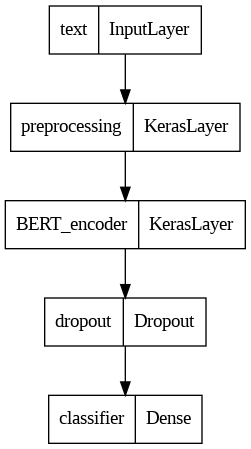

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


Define your loss and evaluation metrics here. Since it is a binary classification use BinaryCrossentropy and BinaryAccuracy

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW).

In past labs, we have been using the Adam optimizer which is a popular choice. However, for this lab we will be using a new optimizier which is meant to improve generalization. The intuition and algoritm behind AdamW can be found in this paper [here](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

Complile the model using the optimizer, loss and metrics you defined above.

In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

Let's train the model for a few epochs.

In [ ]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=train_ds, validation_data=val_ds, epochs=epochs
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
625/625 [==============================] - 182s 286ms/step - loss: 0.5155 - binary_accuracy: 0.7070 - val_loss: 0.3839 - val_binary_accuracy: 0.8284
Epoch 2/10
625/625 [==============================] - 184s 295ms/step - loss: 0.3537 - binary_accuracy: 0.8464 - val_loss: 0.3634 - val_binary_accuracy: 0.8504
Epoch 3/10
625/625 [==============================] - 172s 276ms/step - loss: 0.2666 - binary_accuracy: 0.8923 - val_loss: 0.4269 - val_binary_accuracy: 0.8456
Epoch 4/10
625/625 [==============================] - 172s 275ms/step - loss: 0.1920 - binary_accuracy: 0.9266 - val_loss: 0.5067 - val_binary_accuracy: 0.8432
Epoch 5/10
625/625 [==============================] - 171s 274ms/step - loss: 0.1389 - binary_accuracy: 0.9519 - val_loss: 0.5894 - val_binary_accuracy: 0.8520
Epoch 6/10
625/625 [==============================] - 171s 273ms/step - loss: 0.1049 - binary_accuracy: 0.96

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

782/782 [==============================] - 100s 127ms/step - loss: 0.8691 - binary_accuracy: 0.8546
Loss: 0.8691298961639404
Accuracy: 0.8546000123023987


### Training Result: Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


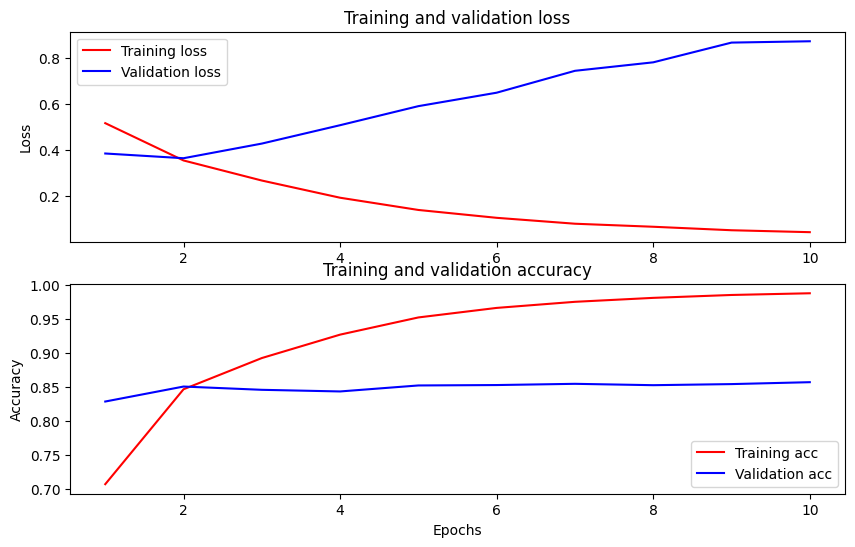

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

As shown in the results, the model shows signs of overfitting after the second epoch - the training score increases, but the validation score decreases.

### Export for inference

Now you just save your fine-tuned model for later use.

Save the model to saved_model_path for inference.

In [ ]:
dataset_name = "imdb"
saved_model_path = "./{}_bert".format(dataset_name.replace("/", "_"))
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(saved_model_path, TIMESTAMP)

classifier_model.save(EXPORT_PATH, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(EXPORT_PATH)

### Result

Here are the results from some example reviews:

In [ ]:
def print_my_examples(inputs, results):
    result_for_printing = [
        f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}"
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep="\n")
    print()


examples = [
    "this is such an amazing movie!",  # this is the same sentence tried earlier
    "The movie was great!",
    "The movie was meh.",
    "The movie was okish.",
    "The movie was terrible...",
    "I loved how the movie was nothing like how it was advertized! I wonder where they spent the $30M budget.",
    "The movie was nothing like how it was advertized! I wonder where they spent the $30M budget.",
    "I regret not watching this movie sooner. This movie is underrated.",
    "asdfasdfgasdggfd ag dsfsdfasdf",
    "Oh, no. Help me, I can't stop watching this movie over and over.",
]

# reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))

# print("Results from the saved model:")
# print_my_examples(examples, reloaded_results)
print("Results from the model in memory:")
print_my_examples(examples, original_results)

Results from the model in memory:
input: this is such an amazing movie! : score: 0.421996
input: The movie was great!           : score: 0.479274
input: The movie was meh.             : score: 0.455165
input: The movie was okish.           : score: 0.531392
input: The movie was terrible...      : score: 0.408353
input: I loved how the movie was nothing like how it was advertized! I wonder where they spent the $30M budget. : score: 0.433615
input: The movie was nothing like how it was advertized! I wonder where they spent the $30M budget. : score: 0.511138
input: I regret not watching this movie sooner. This movie is underrated. : score: 0.365268
input: asdfasdfgasdggfd ag dsfsdfasdf : score: 0.280563
input: Oh, no. Help me, I can't stop watching this movie over and over. : score: 0.452152



These are my observations:

1. Shorter and more straightforward phrases are often accurately classified (input 1 ~ 5).
2. A sign of overfitting is observed in certain words. Inputs 6 and 7 are the same negative reviews - I added the word 'loved' in a sarcastic way to test whether the model can catch the nuance from reading the second sentence. While input 7 is rated as 99% negative, input 6 is rated as 99% positive - revealing that 'loved' is only associated with positivity in the model.
3. Input 9 is rated as positive despite it being a random input.
4. It doesn't catch more nuanced inputs like sarcasm (inputs 6, 8, and 10).

## Discussion

These are some ways to combat over-fitting:

1. Data augmentation

   Based on the explanation from [this article](https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/), I used the [TextAttack](https://textattack.readthedocs.io/en/latest/2notebook/3_Augmentations.html) text augmentation library. After some testing, I employed a `CompositeTransformation` containing:
      * `WordSwapWordNet` - Transforms an input by replacing its words with synonyms provided by WordNet.
      * `WordSwapNeighboringCharacterSwap` - Transformation that swaps neighboring characters.
      * `RepeatModification` - A constraint disallowing the modification of words that have already been modified.
      * `MinWordLength` - A constraint that prevents modifications to words less than a certain character length.
      * 15% augmentation rate
   
   > Ex) "I'd love to go to Japan but the tickets are 500 dollars" --> "I'd love to go to Japan but the tikcets are 500 bucks"

2. Feature selection

   We already have a dedicated text preprocessor that is doing a good job, so I won't do this step.
   
3. Remove layers or number of units per layer
   
   I can't really remove any layers or units, but I can employ a smaller pre-trained model.
    
4. Dropout
   
   I can increase the dropout from 0.15 to 0.40.
   
5. Early stopping
   
   I can fetch the model before it starts to overfit, which is at the second epoch.

6. Hold-out

   I've already done the hold-out by separating the data into train, validation, and test.

See [this article](https://towardsdatascience.com/8-simple-techniques-to-prevent-overfitting-4d443da2ef7d) for more information on overfitting.



### Dealing with overfitting

In [ ]:
!pip install textattack[tensorflow]

In [ ]:
import numpy as np

In [ ]:
# import transformations, contraints, and the Augmenter
# Word Swap by Random Character Deletion
from textattack.transformations import WordSwapRandomCharacterDeletion
# Word Swap by swaps characters with QWERTY adjacent keys... a typical typo scenario
from textattack.transformations import WordSwapQWERTY
# Transformation that swaps neighboring characters.
from textattack.transformations.word_swaps.word_swap_neighboring_character_swap import WordSwapNeighboringCharacterSwap
# Transforms an input by replacing its words with synonyms provided by WordNet.
from textattack.transformations import WordSwapWordNet

# To combine the above tranformation into one
from textattack.transformations import CompositeTransformation

# A constraint disallowing the modification of words which have already been modified.
from textattack.constraints.pre_transformation import RepeatModification
# A constraint that prevents modifications to words less than a certain word character-length.
from textattack.constraints.pre_transformation import MinWordLength

from textattack.augmentation import Augmenter

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Initialize the text augmenter. Too much augmentation is worse than nothing, so I had to balance it.

In [ ]:
# Set up transformation using CompositeTransformation()
transformation = CompositeTransformation(
    [
        WordSwapWordNet(),
    #  WordSwapRandomCharacterDeletion(),
    #  WordSwapQWERTY(skip_first_char=True, skip_last_char=True),
     WordSwapNeighboringCharacterSwap(),
     ]
)
# Set up constraints
constraints = [RepeatModification(), MinWordLength(3)]

# Create augmenter with specified parameters
augmenter = Augmenter(
    transformation=transformation,
    constraints=constraints,
    pct_words_to_swap=0.15,
    transformations_per_example=1,
)

s = "I'd love to go to Japan but the tickets are 500 dollars"
# Augment!
augmenter.augment(s)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


["I'd screw to go to Japan but the tickets are 500 dollars"]

Resolve some dependency issues from installing textattack

In [ ]:
pip install git+https://github.com/boto/botocore

In [ ]:
pip install --upgrade urllib3

In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

Augmentation took very long without a GPU, so I limited the text length.

In [ ]:
the_dataset = raw_train_ds.unbatch() # This turns the dataset into this form: [(text, label), (text, label), ...]

new_data = []

count = 0

for i, (text, label) in enumerate(the_dataset):
  text = text.numpy().decode()

  # keep the original data
  new_data.append((text, label.numpy()))

  # Longer texts took too long to process, so skip them
  if len(text) < 300:

    count += 1

    if count % 50 == 0:
      print(f'newly added {count} so far.')

    text = augmenter.augment(text)[0]
    text = bytes(text, 'utf-8')
    new_data.append((text, label.numpy()))

    # stop at a certain point
    if count >= 1000:
      break

len(new_data)


newly added 50 so far.
newly added 100 so far.
newly added 150 so far.
newly added 200 so far.
newly added 250 so far.
newly added 300 so far.
newly added 350 so far.
newly added 400 so far.
newly added 450 so far.
newly added 500 so far.
newly added 550 so far.
newly added 600 so far.


20633

In [ ]:
aug_dataset = tf.data.Dataset.from_generator(
    lambda: new_data[:20608],
    output_signature=(
        tf.TensorSpec(shape=(None, ), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

aug_dataset = aug_dataset.batch(batch_size)

In [ ]:
# concat the dataset
# bigger_train_ds = #raw_train_ds.concatenate(aug_dataset)

# check the size to double-check
print(aug_dataset.cardinality().numpy())

aug_dataset.cache().prefetch(buffer_size=AUTOTUNE)


-2


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# increased the dropout from 0.15 to 0.4 to reduce overfitting
dropout_rate = 0.4
classifier_model = build_classifier_model(dropout_rate)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = 644
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

I wanted to test my theory, but Colab won't let me use the GPU... Without a GPU, it'll take 2 hrs per epoch.

I wanted to test my changes, but Colab won't let me use the GPU long enough to prepare the data and train. Apparently, it'll take 2 hours to complete one epoch on a CPU. This is because GPUs have more cores (better parallel processing), specialized cores like Tensor Cores, and higher RAM capacity than CPUs, which provide a substantial speedup in training times.

In [ ]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(
    x=aug_dataset, validation_data=val_ds, epochs=epochs, steps_per_epoch=steps_per_epoch
)

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")


Overall, this project was a nice exercise to get some hands-on experience from working with a large language model (LLM) like BERT. I learned how to incorporate a pre-trained LLM in my model to suit my needs.